In [8]:
from sklearn import manifold
import itertools
from sklearn import svm
import tensorflow as tf
import json
from sklearn.decomposition import PCA,SparsePCA,KernelPCA,IncrementalPCA


from scipy import interp
from PIL import Image, ImageEnhance, ImageOps
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt2
import collections
from sklearn.preprocessing import label_binarize
import math
import random
from keras.applications.inception_v3 import InceptionV3 as iv3
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import VGG19

from keras.applications.mobilenet_v2 import MobileNetV2
# from tensorflow.keras.applications.EfficientNetB7 import EfficientNetB7
from keras.applications.densenet import DenseNet121
from keras import layers
from keras.layers import GlobalAveragePooling2D
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as ivr2
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K
import os, os.path
import gc
import time
from keras.preprocessing.image import ImageDataGenerator
import efficientnet.keras as efn 
from efficientnet.keras import center_crop_and_resize, preprocess_input
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics
tf.compat.v1.disable_eager_execution()


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

class Rand_Augment():
    def __init__(self, Numbers=None, max_Magnitude=None):
        self.transforms = [
                            'autocontrast', 
                           'equalize', 
                           'rotate', 
                           'solarize', 
                           'color', 
                           'posterize',
                           'contrast', 
                           'brightness', 
                           'sharpness', 
                           'shearX', 
                           'shearY', 
                           'translateX', 
                           'translateY',
                            "invert"
                          ]
        if Numbers is None:
            self.Numbers = len(self.transforms) // 2
        else:
            self.Numbers = Numbers
        if max_Magnitude is None:
            self.max_Magnitude = 10
        else:
            self.max_Magnitude = max_Magnitude
        fillcolor = 128
        self.ranges = {
            # these  Magnitude   range , you  must test  it  yourself , see  what  will happen  after these  operation ,
            # it is no  need to obey  the value  in  autoaugment.py
            "shearX": np.linspace(0, 0.2, 10),
            "shearY": np.linspace(0, 0.2, 10),
            "translateX": np.linspace(0, 0.2, 10),
            "translateY": np.linspace(0, 0.2, 10),
            "rotate": np.linspace(-30, 30, 10),
            "color": np.linspace(0.0, 0.2, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 231, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
#             0.9
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
#             0.9
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,           
            "invert": [0] * 10
        }
        self.func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fill=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fill=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fill=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fill=fillcolor),
            "rotate": lambda img, magnitude: self.rotate_with_fill(img, magnitude),
            # "rotate": lambda img, magnitude: img.rotate(magnitude * random.choice([-1, 1])),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: img,
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

    def rand_augment(self):
        """Generate a set of distortions.
             Args:
             N: Number of augmentation transformations to apply sequentially. N  is len(transforms)/2  will be best
             M: Max_Magnitude for all the transformations. should be  <= self.max_Magnitude """

        M = np.random.randint(0, self.max_Magnitude, self.Numbers)

        sampled_ops = np.random.choice(self.transforms, self.Numbers)
        return [(op, Magnitude) for (op, Magnitude) in zip(sampled_ops, M)]

    def __call__(self, image):
        operations = self.rand_augment()
        for (op_name, M) in operations:
            operation = self.func[op_name]
            mag = self.ranges[op_name][M]
            image = operation(image, mag)
        return image

    def rotate_with_fill(self, img, magnitude):
        #  I  don't know why  rotate  must change to RGBA , it is  copy  from Autoaugment - pytorch
        rot = img.convert("RGBA").rotate(magnitude)
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

    def test_single_operation(self, image, op_name, M=-1):
        '''
        :param image: image
        :param op_name: operation name in   self.transforms
        :param M: -1  stands  for the  max   Magnitude  in  there operation
        :return:
        '''
        operation = self.func[op_name]
        mag = self.ranges[op_name][M]
        image = operation(image, mag)
        return image
randaugment = Rand_Augment()
def preprocessing_function(image):
    image = Image.fromarray(image.astype(np.uint8))
    image = np.array(randaugment(image))
    return image

def get_feature(select_pre,train):
    pre_trained_model = select_pre(weights='imagenet',
        input_shape=(train.shape[1], train.shape[2], 3), include_top=False, classes=2,pooling = "avg")
#     for layer in pre_trained_model.layers:
#         print(layer.name)
    for layer in pre_trained_model.layers:
        layer.trainable = False
    if select_pre == iv3:
        last_layer = pre_trained_model.get_layer('mixed7')
    elif select_pre == VGG16:
        last_layer = pre_trained_model.get_layer('block5_pool')
    elif select_pre == efn.EfficientNetB0:
        last_layer = pre_trained_model.get_layer('top_activation')
    elif select_pre == MobileNetV2:
        last_layer = pre_trained_model.get_layer('out_relu')
    elif select_pre == VGG19:
        last_layer = pre_trained_model.get_layer('block5_pool')
    elif select_pre == ivr2:
        last_layer = pre_trained_model.get_layer('block8_10_mixed')
    elif select_pre == DenseNet121:
        last_layer = pre_trained_model.get_layer('conv5_block16_concat')
    elif select_pre == Xception:
        last_layer = pre_trained_model.get_layer('block13_pool')#block13_pool
    elif select_pre == ResNet50:
        last_layer = pre_trained_model.get_layer('add_16')
    print ('last layer output shape:', last_layer.output_shape)
    # shape = last_layer.output_shape[-1]
    shape = 1
    for j in last_layer.output_shape:
        if j != None:
            shape *= j
    last_output = last_layer.output
    x = layers.Flatten()(last_output)
    model = Model(pre_trained_model.input, x) 
    train = train.astype("float32")
    feature_train =np.empty((train.shape[0],shape))
    for i in range(0,train.shape[0],64):   
        feature_train[i:i+64] = model.predict(train[i:i+64])
    return feature_train

In [6]:
path = [
    '20201012_nigrosome_image/Control_100/',
        '20201012_nigrosome_image/PD_108/Loss_55/',
        '20201012_nigrosome_image/PD_108/Partial_53/'
       ]
target_names = [ 'Control','Loss+Partial']
data = []
label = []
for e,k in enumerate(path):   
    filelist = sorted(os.listdir(k)) 
    for i in (x for x in filelist if x[-4:]==".jpg"):          
        img = cv2.resize(cv2.imread(k+i), (224, 224), interpolation=cv2.INTER_CUBIC)  
        data.append(img)
        label.append(e if e==0 else 1)  
        
data = np.array(data)
label = np.array(label).reshape(-1,1)
n_classes = label.shape[1]
print(data.shape)
print(label.shape)
collections.Counter(label.reshape(-1))

(208, 224, 224, 3)
(208, 1)


Counter({0: 100, 1: 108})

au
ex
Processing fold # 0
last layer output shape: (None, 7, 7, 1280)
last layer output shape: (None, 7, 7, 1280)
(1716, 62720)


/nfs/Workspace/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.8269230769230769
[[21  8]
 [ 1 22]]
0.8268590455049944
Recall: 0.9565217391304348
Processing fold # 1


<ipython-input-9-3ffc8af8c632>:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr,fpr,tpr))


last layer output shape: (None, 7, 7, 1280)
last layer output shape: (None, 7, 7, 1280)
(1716, 62720)


/nfs/Workspace/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.75
[[20  6]
 [ 7 19]]
0.7499075101738808
Recall: 0.7307692307692307
Processing fold # 2


<ipython-input-9-3ffc8af8c632>:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr,fpr,tpr))


last layer output shape: (None, 7, 7, 1280)
last layer output shape: (None, 7, 7, 1280)
(1716, 62720)


/nfs/Workspace/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.75
[[18  6]
 [ 7 21]]
0.7491651205936921
Recall: 0.75
Processing fold # 3


<ipython-input-9-3ffc8af8c632>:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr,fpr,tpr))


last layer output shape: (None, 7, 7, 1280)
last layer output shape: (None, 7, 7, 1280)
(1716, 62720)


/nfs/Workspace/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.6923076923076923
[[13  8]
 [ 8 23]]
0.6804915514592934
Recall: 0.7419354838709677


<ipython-input-9-3ffc8af8c632>:85: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr,fpr,tpr))


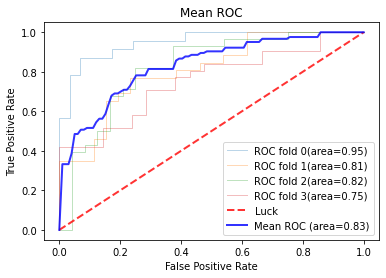

Avg_F1: 0.7516058069329652
Avg_Acc: 0.7548076923076923
Avg_recall: 0.7948066134426583


In [9]:
random.seed(5478)
s = np.arange(label.shape[0])
np.random.shuffle(s)
data = data[s]
label = label[s]

K = 4
num_val_samples = int(len(data)/K)
f1_avg=0.0
acc_avg=0.0
avg_recall=0.0
tprs=[]
aucs=[]
mean_fpr=np.linspace(0,1,100)
aug = True
ex = True
f1_ = 0
print("au" if aug==True else "noau")
print("ex" if ex==True else "noex")
cm=[]
for i in range(K):
    print('Processing fold #', i)
    x_test = data[i*num_val_samples : (i+1)*num_val_samples]/255.
    y_test = label[i*num_val_samples : (i+1)*num_val_samples]
    x_train = np.concatenate( 
                         [data[: i*num_val_samples],
                         data[(i+1)*num_val_samples :]],
                         axis = 0)
    y_train = np.concatenate(
                         [label[: i*num_val_samples],
                         label[(i+1)*num_val_samples :]],
                         axis = 0)
    if aug == True:
        aug_img =[]
        for c in range(x_train.shape[0]):   
            for j in range(10):
                x_train = np.concatenate((x_train,preprocessing_function(x_train[c]).reshape(-1,224,224,3)))
                y_train = np.concatenate((y_train,y_train[c].reshape(-1,1)))
                
    t = np.arange(y_train.shape[0])
    np.random.shuffle(t)
    x_train = x_train[t]/255.
    y_train = y_train[t]
    if ex == True:
        train_ex = get_feature(efn.EfficientNetB0,x_train)
        test_ex = get_feature(efn.EfficientNetB0,x_test)
            
    else:
        train_ex = x_train.reshape(-1,224*224*3)
        test_ex = x_test.reshape(-1,224*224*3)


    train_num = train_ex.shape[0]
    test_num = test_ex.shape[0]
    

    print(train_ex.shape)
    predictor = svm.SVC(gamma='scale', C=1.0, decision_function_shape='ovr', kernel='rbf')
    # predictor.fit(x_train, y_train)
    y_score = predictor.fit(train_ex, y_train).decision_function(test_ex).reshape((-1,1))

    result = predictor.predict(test_ex)
    

    # print(result)
    # print(y_test)
    accurancy = np.sum(np.equal(result, y_test.reshape(-1))) / len(y_test)
    print(accurancy)
    from sklearn.metrics import confusion_matrix,f1_score
    print(confusion_matrix(y_true=y_test, y_pred=result))
    cm.append(confusion_matrix(y_true=y_test, y_pred=result))
    f1 = f1_score(y_true=y_test, y_pred=result, average='macro')
    print(f1)
    if f1>f1_:
        predictor_ = predictor
    print('Recall:', metrics.recall_score(y_true=y_test, y_pred=result))
    f1_avg+=f1_score(y_true=y_test, y_pred=result, average='macro')
    acc_avg+=accurancy
    avg_recall+= metrics.recall_score(y_true=y_test, y_pred=result)



    fpr,tpr,thresholds=roc_curve(y_test[:,0],y_score[:,0])

    tprs.append(interp(mean_fpr,fpr,tpr))
    tprs[-1][0]=0.0
    roc_auc=auc(fpr,tpr)
    aucs.append(roc_auc)
    
    plt.plot(fpr,tpr,lw=1,alpha=0.3,label='ROC fold %d(area=%0.2f)'% (i,roc_auc))

plt.plot([0,1],[0,1],linestyle='--',lw=2,color='r',label='Luck',alpha=.8)
mean_tpr=np.mean(tprs,axis=0)
mean_tpr[-1]=1.0
mean_auc=auc(mean_fpr,mean_tpr)#计算平均AUC值
std_auc=np.std(tprs,axis=0)
plt.plot(mean_fpr,mean_tpr,color='b',label=r'Mean ROC (area=%0.2f)'%mean_auc,lw=2,alpha=.8)
std_tpr=np.std(tprs,axis=0)
tprs_upper=np.minimum(mean_tpr+std_tpr,1)
tprs_lower=np.maximum(mean_tpr-std_tpr,0)
# plt.fill_between(mean_tpr,tprs_lower,tprs_upper,color='gray',alpha=.2)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC')
plt.legend(loc='lower right')
# plt.savefig('None.png',dpi=600)
plt.show()     


print("Avg_F1:",f1_avg/K)
print("Avg_Acc:",acc_avg/K)
print("Avg_recall:",avg_recall/K)

Normalized confusion matrix
[[0.72413793 0.27586207]
 [0.04347826 0.95652174]]


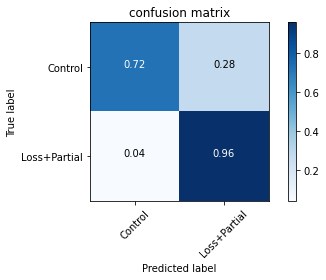

Normalized confusion matrix
[[0.76923077 0.23076923]
 [0.26923077 0.73076923]]


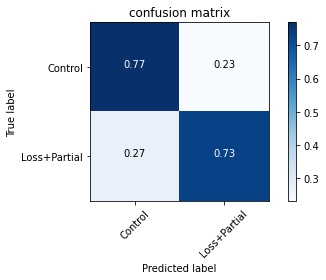

Normalized confusion matrix
[[0.75 0.25]
 [0.25 0.75]]


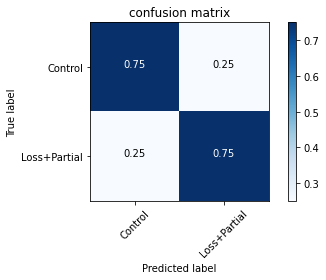

Normalized confusion matrix
[[0.61904762 0.38095238]
 [0.25806452 0.74193548]]


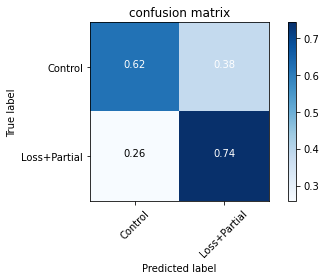

In [10]:
for e,i in enumerate(cm):
    plt.figure()
    plot_confusion_matrix(i, classes=target_names,normalize=True,
                        title="confusion matrix")
#     plt.savefig('None'+str(e)+'.png',dpi=600)
    plt.show()     

In [6]:
#     data = {
#         '_': ["Transfer+Aug","Transfer","Augmented","Baseline"],
#         'F1': [0.78,0.71,0.59,0.61],
#         'ACC': [0.78,0.71,0.63,0.64],
#         'AUC': [0.82,0.80,0.65,0.69]
        
#     }

#     df = pd.DataFrame(data)

#     fig, ax = plt.subplots(figsize=(3, 3))

#     ax.axis('off')
#     ax.axis('tight')

#     tb = ax.table(cellText=df.values,
#                   colLabels=df.columns,
#                   bbox=[0, 0, 1, 1],
#                   )

#     tb[0,0].set_facecolor('#363636')
#     tb[0, 1].set_facecolor('#363636')
#     tb[0,2].set_facecolor('#363636')
#     tb[0, 3].set_facecolor('#363636')
#     tb[0, 0].set_text_props(color='w')
#     tb[0, 1].set_text_props(color='w')
#     tb[0, 2].set_text_props(color='w')
#     tb[0, 3].set_text_props(color='w')
#     tb[1, 1].set_text_props(color='r')
#     tb[1, 2].set_text_props(color='r')
#     tb[1, 3].set_text_props(color='r')
#     plt.savefig('table.png',dpi=600)

#     plt.show()
